# <div style="text-align:center">Final Assignmeint in Coursera Capstone course</div>
## Exploring different cuisines (restaurants) in boroughs and neighborhoods in Toronto
## This notebook contains all calculations and visualization data which was used to cluster Toronto neighborhoods dependind on restaurant data from FourSquares


### 0. First: Installation of the all packages for work

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c districtdatalabs yellowbrick
!pip install folium==0.5.0
!pip install yellowbrick

     |████████████████████████████████| 81kB 16.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
     |████████████████████████████████| 389kB 8.6MB/s eta 0:00:01


### 0. And import needed modules

In [3]:
import pandas as pd
import folium
from folium import plugins
import requests
import json
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from PIL import Image
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

### 1. I used the dataset with postal codes, borougs and neighborhoods in Toronto, Canada.
### For the geospatial data I used the dataframe provided for this course.

In [4]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df=df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df['Neighbourhood']=df['Neighbourhood'].replace('Not assigned',df['Borough'])
url='http://cocl.us/Geospatial_data'
gd=pd.read_csv(url)
gd.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df.set_index('Postcode', inplace=True)
gd.set_index('Postcode', inplace=True)
mergedDf = df.merge(gd, left_index=True, right_index=True)
mergedDf=mergedDf.reset_index()
mergedDf.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 2. It's easy to show all boroughs on map using folium package. The boroughs and FSA codes are labelled on map.

In [5]:
latitude=43.653226
longitude=-79.383184


toronto_all=mergedDf.copy()
print(toronto_all.shape)
#print(toronto_all.head())

map_dots = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, borough, neighborhood, fsa in zip(toronto_all['Latitude'], toronto_all['Longitude'], toronto_all['Borough'], toronto_all['Neighbourhood'], toronto_all['Postcode']):
    label = '{}, {}'.format(borough, fsa)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#3d3c42',
        fill=True,
        fill_color='#01ffff',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_dots)  
    
map_dots

(103, 5)


### 3. Next I'm going to use Foursquares API to gather information abo

In [78]:
# The code was removed by Watson Studio for sharing.

In [79]:
bn_data = mergedDf.copy()
bn_data.rename(columns={'Postcode':'FSA'}, inplace=True)
bn_data.head()

,FSA,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [80]:
def getNearbyRestaurants(fsa, boroughs, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for fsa, borough, name, lat, lng in zip(fsa,boroughs, names, latitudes, longitudes):
        print(fsa,' ',borough,' ',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            fsa,
            borough,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['FSA',
                             'Borough',
                             'Neighbourhood',
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [81]:
bn_restaurants = getNearbyRestaurants(fsa=bn_data['FSA'],
                                      boroughs=bn_data['Borough'],
                                      names=bn_data['Neighbourhood'],
                                      latitudes=bn_data['Latitude'],
                                      longitudes=bn_data['Longitude']
                                  )

M1B   Scarborough   Rouge,Malvern
M1C   Scarborough   Highland Creek,Rouge Hill,Port Union
M1E   Scarborough   Guildwood,Morningside,West Hill
M1G   Scarborough   Woburn
M1H   Scarborough   Cedarbrae
M1J   Scarborough   Scarborough Village
M1K   Scarborough   East Birchmount Park,Ionview,Kennedy Park
M1L   Scarborough   Clairlea,Golden Mile,Oakridge
M1M   Scarborough   Cliffcrest,Cliffside,Scarborough Village West
M1N   Scarborough   Birch Cliff,Cliffside West
M1P   Scarborough   Dorset Park,Scarborough Town Centre,Wexford Heights
M1R   Scarborough   Maryvale,Wexford
M1S   Scarborough   Agincourt
M1T   Scarborough   Clarks Corners,Sullivan,Tam O'Shanter
M1V   Scarborough   Agincourt North,L'Amoreaux East,Milliken,Steeles East
M1W   Scarborough   L'Amoreaux West
M1X   Scarborough   Upper Rouge
M2H   North York   Hillcrest Village
M2J   North York   Fairview,Henry Farm,Oriole
M2K   North York   Bayview Village
M2L   North York   Silver Hills,York Mills
M2M   North York   Newtonbrook,Will

In [82]:
def get_category_type(row):
    try:
        categories_list = row['Venue Category']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['shortName']

# filter the category for each row
bn_restaurants['Venue Category'] = bn_restaurants.apply(get_category_type, axis=1)

In [83]:
print(bn_restaurants.shape)
bn_restaurants.head()

(577, 9)


,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Wonder Season Chinese Restaurant,43.765354,-79.190536,None
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka
2,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant & Bar,43.774780,-79.241043,Restaurant
3,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,terry's restaurant,43.774969,-79.240872,Italian
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant,43.774702,-79.241175,None


In [84]:
bn_restaurants['Venue Category'].unique()

array([None, 'Hakka', 'Restaurant', 'Italian', 'Thai', 'Indian',
       'Chinese', 'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches',
       'Furniture / Home', 'Asian', 'Diner', 'Japanese', 'Café',
       'Eastern European', 'American', 'Sushi', 'African', 'Caribbean',
       'Lounge', 'Persian', 'Lebanese', 'Greek', 'Mediterranean',
       'Ice Cream', 'Music Venue', 'Entertainment', 'Tapas',
       'New American', 'Fast Food', 'Pub', 'Movie Theater', 'Ethiopian',
       'Theme Restaurant', 'Dim Sum', 'Gastropub', 'Modern European',
       'Spanish', 'Molecular Gastronomy', 'Mongolian', 'Food', 'Beer Bar',
       'Bar', 'Szechuan', 'Vietnamese', 'French', 'Wine Bar',
       'Deli / Bodega', 'Brewery', 'Steakhouse', 'Noodles',
       'Vegetarian / Vegan', 'Nightclub', 'Cantonese', 'Dumplings',
       'Portuguese', 'Mexican', 'Cuban', 'Nightlife', 'Latin American',
       'Pizza'], dtype=object)

In [85]:
bn_restaurants=bn_restaurants.dropna()
bn_restaurants.drop(bn_restaurants[(bn_restaurants['Venue Category']=='Furniture / Home') | 
                                   (bn_restaurants['Venue Category']=='Movie Theater') | 
                                   (bn_restaurants['Venue Category']=='Nightclub') | 
                                   (bn_restaurants['Venue Category']=='Nightlife') | 
                                   (bn_restaurants['Venue Category']=='Entertainment') |
                                   (bn_restaurants['Venue Category']=='Music Venue')].index,inplace=True)

In [86]:
bn_restaurants['Venue Category'].unique()

array(['Hakka', 'Restaurant', 'Italian', 'Thai', 'Indian', 'Chinese',
       'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches', 'Asian',
       'Diner', 'Japanese', 'Café', 'Eastern European', 'American',
       'Sushi', 'African', 'Caribbean', 'Lounge', 'Persian', 'Lebanese',
       'Greek', 'Mediterranean', 'Ice Cream', 'Tapas', 'New American',
       'Fast Food', 'Pub', 'Ethiopian', 'Theme Restaurant', 'Dim Sum',
       'Gastropub', 'Modern European', 'Spanish', 'Molecular Gastronomy',
       'Mongolian', 'Food', 'Beer Bar', 'Bar', 'Szechuan', 'Vietnamese',
       'French', 'Wine Bar', 'Deli / Bodega', 'Brewery', 'Steakhouse',
       'Noodles', 'Vegetarian / Vegan', 'Cantonese', 'Dumplings',
       'Portuguese', 'Mexican', 'Cuban', 'Latin American', 'Pizza'],
      dtype=object)

In [87]:
print('There are {} uniques categories.'.format(len(bn_restaurants['Venue Category'].unique())))
print('There are {} uniques boroughs.'.format(len(bn_restaurants['Borough'].unique())))
print('There are {} uniques neighborhoods.'.format(len(bn_restaurants['Neighbourhood'].unique())))
print('There are {} venues.'.format((bn_restaurants['Venue'].count())))

There are 56 uniques categories.
There are 10 uniques boroughs.
There are 57 uniques neighborhoods.
There are 557 venues.


In [88]:
bn_grouped=bn_restaurants.copy()
#bn_grouped=bn_grouped.groupby(['FSA','Borough','Neighbourhood'])['Venue Category'].apply(','.join).reset_index()
bn_grouped=bn_grouped.groupby(['FSA'])['Venue'].count().reset_index()
bn_grouped.rename(columns={'Venue':'Count'}, inplace=True)

#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
bn_grouped.head()

,FSA,Count
0,M1H,4
1,M1P,2
2,M1R,3
3,M1S,4
4,M1T,3


In [89]:
!wget --quiet https://raw.githubusercontent.com/azulgris/coursera_capstone/master/Toronto_Map_FSA.geojson -O Toronto_Map_FSA.geojson
t_js=r'Toronto_Map_FSA.geojson'
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [90]:
fsa_geo=mergedDf.loc[:,['Postcode','Borough','Latitude','Longitude']]
fsa_geo.drop(fsa_geo[fsa_geo['Postcode']=='M7R'].index,inplace=True)
print(fsa_geo.shape)
#limit = 92
#fsa1 = fsa1.iloc[0:limit, :]
#print(fsa1.shape)
fsa_geo.head()

(102, 4)


,Postcode,Borough,Latitude,Longitude
0,M1B,Scarborough,43.806686,-79.194353
1,M1C,Scarborough,43.784535,-79.160497
2,M1E,Scarborough,43.763573,-79.188711
3,M1G,Scarborough,43.770992,-79.216917
4,M1H,Scarborough,43.773136,-79.239476


In [91]:
latitude=43.653226
longitude=-79.383184
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

toronto_map.choropleth(geo_data=t_js,
    data = bn_grouped,
    columns=['FSA','Count'],
    key_on='feature.properties.CFSAUID',
    fill_color='PuRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurants by FSA') 


# instantiate a mark cluster object for the incidents in the dataframe
rests = plugins.MarkerCluster().add_to(toronto_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(fsa_geo['Latitude'], fsa_geo['Longitude'], fsa_geo['Postcode']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(rests)   
    
toronto_map

In [92]:
bn_restaurants.head()

,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka
2,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Terry's Restaurant & Bar,43.774780,-79.241043,Restaurant
3,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,terry's restaurant,43.774969,-79.240872,Italian
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai One On,43.774468,-79.241268,Thai
6,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian


In [93]:
topvenues=bn_restaurants.copy()
topvenues=topvenues.groupby(['Venue Category']).count().reset_index()
cuisines=('Chinese', 'Japanese', 'Italian', 'Asian','American', 'Indian', 'Caribbean', 'Thai', 'New American',
       'Vietnamese', 'Greek', 'Middle Eastern','Mongolian', 'Korean', 'Spanish',
       'Latin American', 'Eastern European', 'Szechuan', 'French', 'African', 'Mexican',
       'Modern European', 'Portuguese', 'Hakka', 'Cuban', 'Ethiopian', 'Persian',
    'Deli / Bodega', 'Lebanese', 'Cantonese', 'Mediterranean')

topvenues=topvenues.loc[:,['Venue Category','FSA']]
topvenues.rename(columns={'FSA':'Count'},inplace=True)

topvenues.sort_values(by='Count', ascending=True, inplace=True)
topvenues=topvenues[topvenues['Venue Category'].isin(cuisines)]
topvenues.set_index('Venue Category', inplace=True)
cu_top10 = topvenues['Count'].tail(10)
cu_top10.head()

Venue Category
New American    10
Vietnamese      10
Thai            10
Caribbean       12
Indian          19
Name: Count, dtype: int64

In [94]:
topboroughs=bn_restaurants.copy()
#delete Restaurants without Cuisine
topboroughs=topboroughs[topboroughs['Venue Category'].isin(cuisines)]
topboroughs=topboroughs.groupby(['Borough']).count().reset_index()
topboroughs=topboroughs.loc[:,['Borough','FSA']]
topboroughs.rename(columns={'FSA':'Count'},inplace=True)
topboroughs.sort_values(by='Count', ascending=True, inplace=True)
topboroughs.set_index('Borough', inplace=True)
topboroughs = topboroughs['Count'].tail(10)
topboroughs.head()

Borough
Etobicoke          1
Mississauga        1
York               2
East York          5
Central Toronto    7
Name: Count, dtype: int64

In [95]:
print(plt.style.available)

['seaborn-ticks', 'seaborn-paper', 'classic', 'tableau-colorblind10', 'bmh', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-muted', 'grayscale', 'seaborn-colorblind', 'seaborn-pastel', 'Solarize_Light2', 'fast', 'fivethirtyeight', 'dark_background', 'seaborn-dark', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-notebook', 'ggplot', 'seaborn-deep', 'seaborn-whitegrid', '_classic_test', 'seaborn-bright', 'seaborn']


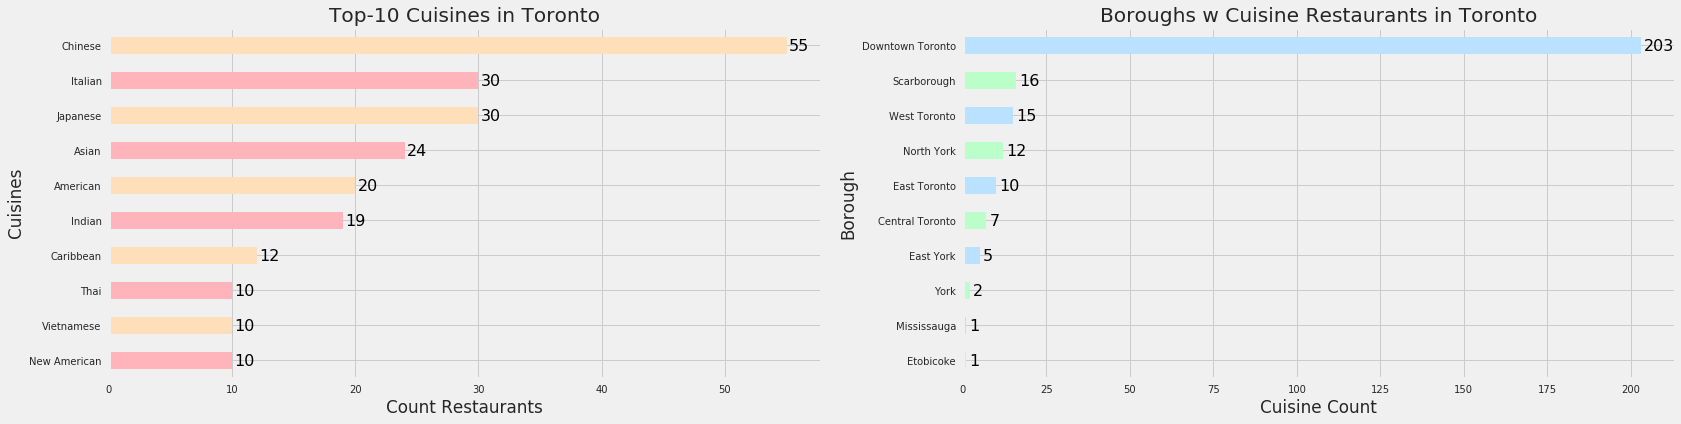

In [164]:
plt.style.use('fivethirtyeight')
colors1=['#ffb3ba','#ffdfba']
colors2=['#baffc9','#bae1ff']
colors=['#ffb3ba','#ffdfba','#ffffba','#baffc9','#bae1ff']

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
cu_top10.plot(kind='barh', figsize=(25,6), color=colors1, ax=ax0) # add to subplot 1
for a in ax0.patches:
    #print(a,' ',str(a.get_y()))
    ax0.annotate(str(a.get_width()),(a.get_width()+0.2,a.get_y()+0.1), color='black',fontsize=16)
ax0.set_xlabel('Count Restaurants')
ax0.set_ylabel('Cuisines')
ax0.set_title('Top-10 Cuisines in Toronto')

# Subplot 2: Line plot
topboroughs.plot(kind='barh', figsize=(25,6), color=colors2, ax=ax1) # add to subplot 2
for a in ax1.patches:
    #print(a,' ',str(a.get_y()))
    ax1.annotate(str(a.get_width()),(a.get_width()+0.9,a.get_y()+0.1), color='black',fontsize=16)
ax1.set_xlabel('Cuisine Count')
ax1.set_ylabel('Borough')
ax1.set_title('Boroughs w Cuisine Restaurants in Toronto')
#ax1.legend([])
#ax1.get_legend().remove()

plt.show()

In [97]:
cuisines_all=topvenues.reset_index()
#cuisines_all.sort_values(by='Count', ascending=False, inplace=True)
cuisines_all.set_index(['Venue Category'],inplace=True)
cuisines_all.head()

,Count
Venue Category,
Mediterranean,1
Ethiopian,1
Deli / Bodega,1
Cuban,1
Hakka,1


In [98]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):
    
    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    #print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
   # for i, tiles in enumerate(tiles_per_category):
   #     print (cuisines_all.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()
    #dark backgr
    #plt.style.use('dark_background')
    #plt.style.use('seaborn-dark-palette')

    # use matshow to display the waffle chart
   # colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    #plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_title('Cuisines Count', fontsize=14)
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    #ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.xticks([])
    plt.yticks([])
   
    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
            #label_str = category 
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            #label_str = category
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        #ncol=len(categories),
        ncol=5,
        bbox_to_anchor=(0.,-1.2,1,0.)
    )

In [167]:
print(plt.style.available)

['seaborn-ticks', 'seaborn-paper', 'classic', 'tableau-colorblind10', 'bmh', 'seaborn-poster', 'seaborn-darkgrid', 'seaborn-muted', 'grayscale', 'seaborn-colorblind', 'seaborn-pastel', 'Solarize_Light2', 'fast', 'fivethirtyeight', 'dark_background', 'seaborn-dark', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-notebook', 'ggplot', 'seaborn-deep', 'seaborn-whitegrid', '_classic_test', 'seaborn-bright', 'seaborn']


<Figure size 640x480 with 0 Axes>

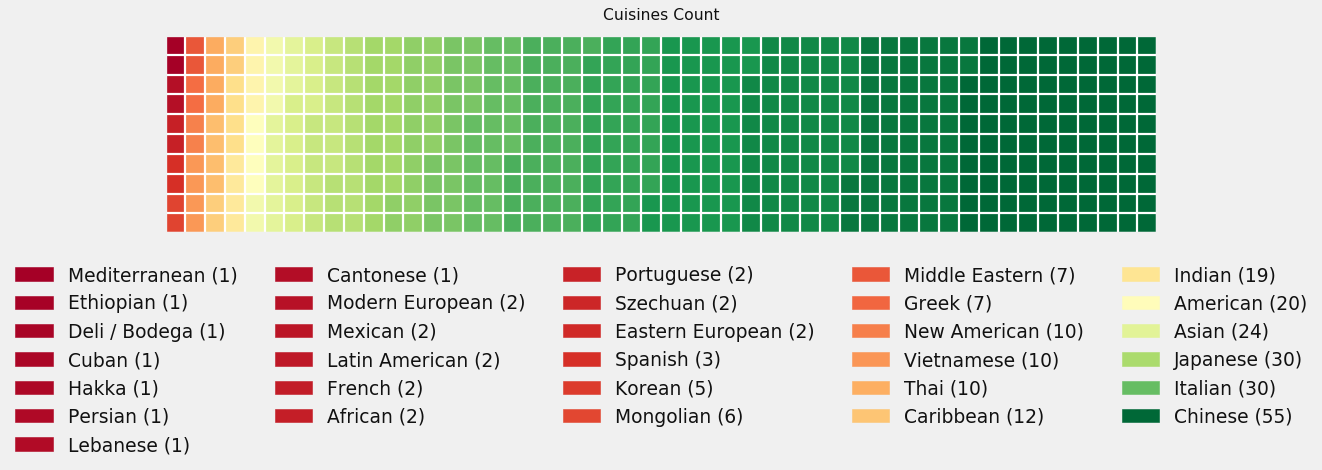

In [174]:
#mpl.cm.get_cmap(name=None, lut=None)
#bbox_to_anchor=(0., -0.2, 0.95, .1)
plt.style.use('fivethirtyeight')
width = 50 # width of chart
height = 10 # height of chart

categories = cuisines_all.index.values # categories
values = cuisines_all['Count'] # correponding values of categories

colormap = plt.cm.RdYlGn # color map class

create_waffle_chart(categories, values, height, width, colormap)

In [166]:
dwtnwn_tor=bn_restaurants.copy()
dwtnwn_tor=dwtnwn_tor[dwtnwn_tor['Venue Category'].isin(cuisines)]
dwtnwn_tor = dwtnwn_tor[dwtnwn_tor['Borough'].str.contains('Downtown Toronto')].reset_index(drop=True)
dwtnwn_tor.head()

,FSA,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Tender Trap Restaurant,43.667724,-79.369485,Chinese
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Rainbow Restaurant,43.667416,-79.369350,Indian
2,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,Athenas Bar & Restaurant,43.664134,-79.366248,Greek
3,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Scaccia Restaurant,43.668794,-79.388296,Italian
4,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Ehwa Restaurant,43.667861,-79.384884,Asian


In [101]:
dwtnwn_tor_onehot = pd.get_dummies(dwtnwn_tor[['Venue Category']], prefix="", prefix_sep="")
dwtnwn_tor_onehot.head()

,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
dwtnwn_tor_onehot['Neighbourhood'] = dwtnwn_tor['Neighbourhood'] 
fixed_columns1 = [dwtnwn_tor_onehot.columns[-1]] + list(dwtnwn_tor_onehot.columns[:-1])
dwtnwn_tor_onehot = dwtnwn_tor_onehot[fixed_columns1]
dwtnwn_tor_onehot.head()

,Neighbourhood,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
0,"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Cabbagetown,St. James Town",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"Cabbagetown,St. James Town",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Church and Wellesley,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Church and Wellesley,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
dwtnwn_tor['Venue Category'].unique()

array(['Chinese', 'Indian', 'Greek', 'Italian', 'Asian', 'New American',
       'Thai', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese'], dtype=object)

In [104]:
cuisines_dwntwn=['Chinese', 'Indian', 'Greek', 'New American', 'Asian', 'Thai',
       'Italian', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese']

In [105]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts()
dwtnwn_tor_grouped.head()

Neighbourhood           Venue Category
Adelaide,King,Richmond  Chinese           4
                        Indian            3
                        Japanese          3
                        American          2
                        Asian             2
Name: Venue Category, dtype: int64

In [106]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts().unstack().fillna(0).astype(int)
print(dwtnwn_tor_grouped.shape)
#pd.set_option('display.max_columns', None)
dwtnwn_tor_grouped.head()

(16, 22)


Venue Category,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0,2,2,0,2,4,0,0,0,1,3,2,3,0,1,0,0,1,0,0,0,1
Berczy Park,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
Central Bay Street,0,3,1,0,1,10,0,0,1,0,1,2,2,0,2,1,0,0,0,2,1,1
"Chinatown,Grange Park,Kensington Market",0,0,3,1,1,19,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,5


In [107]:
flattened = pd.DataFrame(dwtnwn_tor_grouped.to_records())
flattened['Total']=flattened.sum(axis=1)
flattened.sort_values(by='Total', ascending=True, inplace=True)
flattened.drop(['Total'], axis=1, inplace=True)
flattened=flattened.set_index('Neighbourhood')


flattened.head()

,African,American,Asian,Cantonese,Caribbean,Chinese,Deli / Bodega,Ethiopian,French,Greek,Indian,Italian,Japanese,Korean,Middle Eastern,Modern European,Mongolian,New American,Spanish,Szechuan,Thai,Vietnamese
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,
Christie,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
"Harbord,University of Toronto",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Cabbagetown,St. James Town",0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
Berczy Park,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
Harbourfront,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


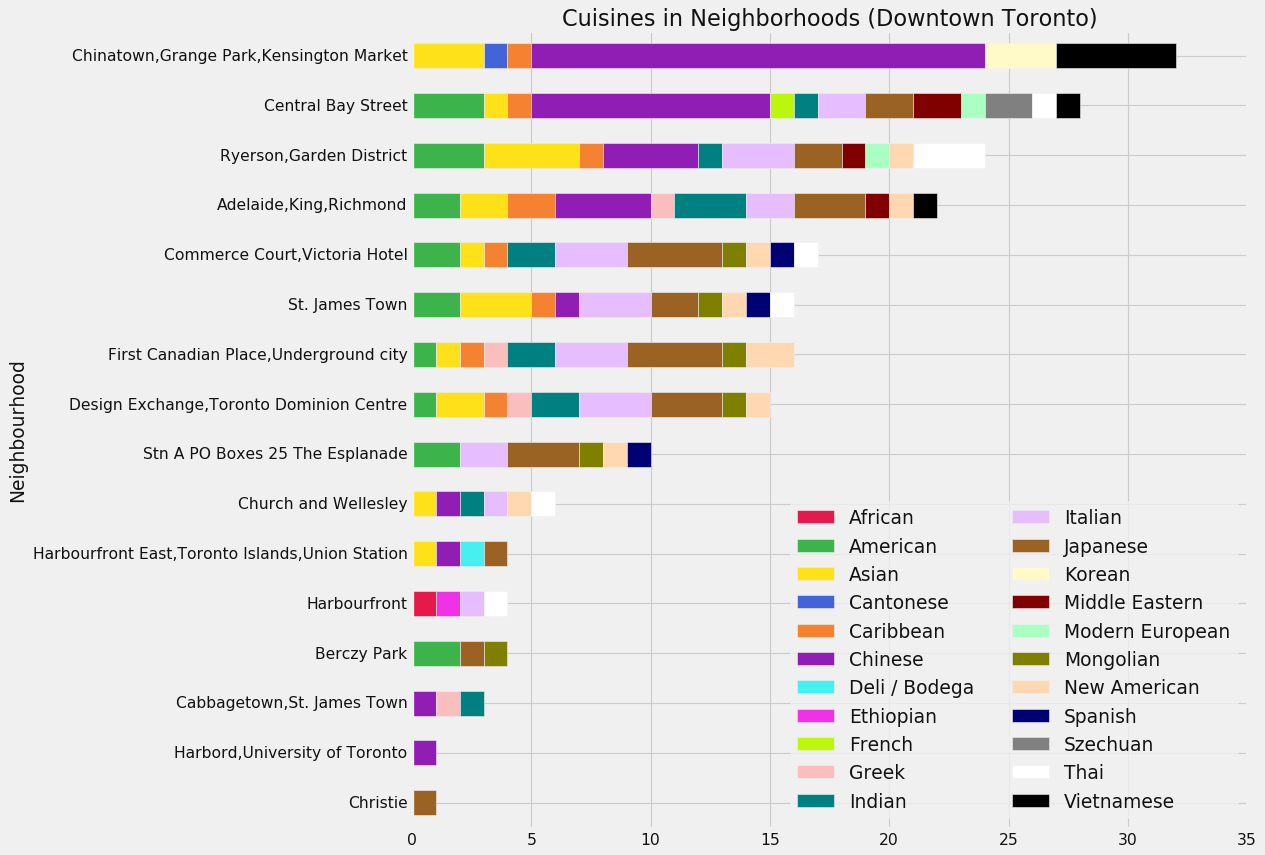

In [175]:
distinctcolors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
              '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
              '#000075', '#808080', '#ffffff', '#000000']
ax=flattened.plot.barh(stacked=True,figsize=(12,12),color=distinctcolors);
ax.set_title('Cuisines in Neighborhoods (Downtown Toronto)')
ax.legend(loc='best',ncol=2,frameon=True,framealpha=0.8)
#

In [176]:
topneighs=bn_restaurants.copy().reset_index()
#topneighs=topneighs[topneighs['Venue Category'].isin(cuisines)]
topneighs_onehot = pd.get_dummies(topneighs[['Venue Category']], prefix="", prefix_sep="")
topneighs_onehot['Neighbourhood'] = topneighs['Neighbourhood'] 
fixed_columns = [topneighs_onehot.columns[-1]] + list(topneighs_onehot.columns[:-1])
topneighs_onehot = topneighs_onehot[fixed_columns]
topneighs_onehot.head()

,Neighbourhood,African,American,Asian,Bar,Beer Bar,Breakfast,Brewery,Café,Cantonese,Caribbean,Chinese,Cuban,Deli / Bodega,Dim Sum,Diner,Dumplings,Eastern European,Ethiopian,Fast Food,Food,French,Gastropub,Greek,Hakka,Ice Cream,Indian,Italian,Japanese,Korean,Latin American,Lebanese,Lounge,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Mongolian,New American,Noodles,Persian,Pizza,Portuguese,Pub,Restaurant,Sandwiches,Spanish,Steakhouse,Sushi,Szechuan,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wine Bar
0,Cedarbrae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cedarbrae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Cedarbrae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cedarbrae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"Dorset Park,Scarborough Town Centre,Wexford He...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [177]:
topneighs_grouped = topneighs_onehot.groupby('Neighbourhood').mean().reset_index()
topneighs_grouped

,Neighbourhood,African,American,Asian,Bar,Beer Bar,Breakfast,Brewery,Café,Cantonese,Caribbean,Chinese,Cuban,Deli / Bodega,Dim Sum,Diner,Dumplings,Eastern European,Ethiopian,Fast Food,Food,French,Gastropub,Greek,Hakka,Ice Cream,Indian,Italian,Japanese,Korean,Latin American,Lebanese,Lounge,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Mongolian,New American,Noodles,Persian,Pizza,Portuguese,Pub,Restaurant,Sandwiches,Spanish,Steakhouse,Sushi,Szechuan,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wine Bar
0,"Adelaide,King,Richmond",0.000000,0.048780,0.048780,0.024390,0.000000,0.024390,0.000000,0.00,0.000000,0.048780,0.097561,0.000000,0.000000,0.024390,0.000000,0.000000,0.00,0.000000,0.024390,0.00000,0.000000,0.024390,0.024390,0.00,0.000000,0.073171,0.048780,0.073171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.0,0.000000,0.000000,0.292683,0.024390,0.000000,0.000000,0.024390,0.00000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000
1,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Alderwood,Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bedford Park,Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Berczy Park,0.000000,0.153846,0.000000,0.076923,0.076923,0.076923,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.07

In [178]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [193]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = topneighs_grouped['Neighbourhood']

for ind in np.arange(topneighs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(topneighs_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Restaurant,Chinese,Japanese,Indian,American
1,Agincourt,Korean,Sandwiches,Restaurant,Chinese,Wine Bar
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese,Wine Bar,Diner,Indian,Ice Cream
3,"Alderwood,Long Branch",Pizza,Korean,Dim Sum,Ice Cream,Hakka
4,"Bathurst Manor,Downsview North,Wilson Heights",Middle Eastern,Sandwiches,Wine Bar,Dim Sum,Ice Cream


In [194]:
topneighs_grouped.head()

,Neighbourhood,African,American,Asian,Bar,Beer Bar,Breakfast,Brewery,Café,Cantonese,Caribbean,Chinese,Cuban,Deli / Bodega,Dim Sum,Diner,Dumplings,Eastern European,Ethiopian,Fast Food,Food,French,Gastropub,Greek,Hakka,Ice Cream,Indian,Italian,Japanese,Korean,Latin American,Lebanese,Lounge,Mediterranean,Mexican,Middle Eastern,Modern European,Molecular Gastronomy,Mongolian,New American,Noodles,Persian,Pizza,Portuguese,Pub,Restaurant,Sandwiches,Spanish,Steakhouse,Sushi,Szechuan,Tapas,Thai,Theme Restaurant,Vegetarian / Vegan,Vietnamese,Wine Bar
0,"Adelaide,King,Richmond",0.0,0.04878,0.04878,0.02439,0.0,0.02439,0.0,0.0,0.0,0.04878,0.097561,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.02439,0.0,0.0,0.02439,0.02439,0.0,0.0,0.073171,0.04878,0.073171,0.00,0.0,0.0,0.0,0.0,0.0,0.02439,0.0,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.292683,0.02439,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.02439,0.0
1,Agincourt,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.250000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.250000,0.25000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,1.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,"Alderwood,Long Branch",0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,0.50,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.5,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,"Bathurst Manor,Downsview North,Wilson Heights",0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.50000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.50000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


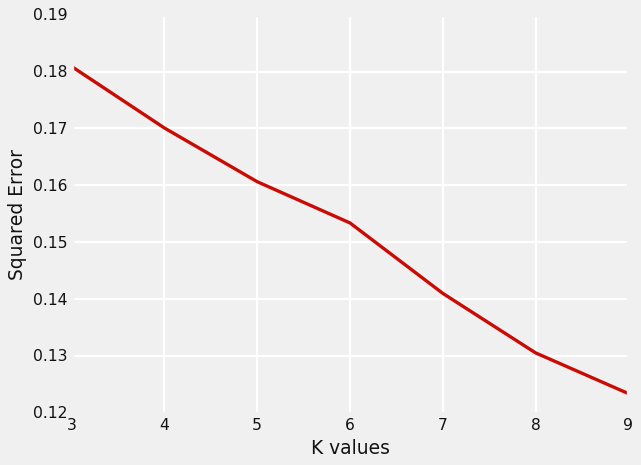

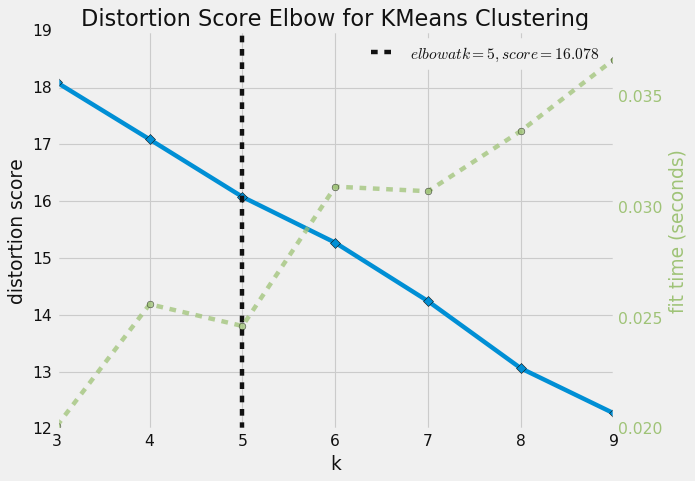

In [184]:
neighborhoods_clustering=topneighs_grouped.drop('Neighbourhood',1)


error_cost=[]

for i in range(3,10):
    KM=KMeans(n_clusters=i,max_iter=100)
    KM.fit(neighborhoods_clustering)
    error_cost.append(KM.inertia_/100)
    
plt.plot(range(3,10),error_cost,color='r',linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error')
plt.grid(color='white',linestyle='-',linewidth=2)
plt.show()


model=KMeans()
visualizer=KElbowVisualizer(model,k=(3,10))
visualizer.fit(neighborhoods_clustering)
visualizer.show()

In [195]:
# set number of clusters
kclusters = 5

topneighs_grouped_clustering = topneighs_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(topneighs_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [196]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [197]:
topneighs_merged = toronto_all

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
topneighs_merged = topneighs_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

topneighs_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,NaN,NaN,NaN,NaN,NaN,NaN
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,NaN,NaN,NaN,NaN,NaN,NaN
3,M1G,Scarborough,Woburn,43.770992,-79.216917,NaN,NaN,NaN,NaN,NaN,NaN
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka,Thai,Restaurant,Italian,Wine Bar


In [198]:
topneighs_merged=topneighs_merged.dropna()
topneighs_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Hakka,Thai,Restaurant,Italian,Wine Bar
10,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,2.0,Indian,Chinese,Wine Bar,Diner,Ice Cream
11,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849,0.0,Breakfast,Middle Eastern,Wine Bar,Diner,Ice Cream
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,0.0,Korean,Sandwiches,Restaurant,Chinese,Wine Bar
13,M1T,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302,2.0,Chinese,Wine Bar,Diner,Indian,Ice Cream


In [199]:
topneighs_merged['Cluster Labels'] = topneighs_merged['Cluster Labels'].astype(int)
topneighs_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka,Thai,Restaurant,Italian,Wine Bar
10,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,2,Indian,Chinese,Wine Bar,Diner,Ice Cream
11,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849,0,Breakfast,Middle Eastern,Wine Bar,Diner,Ice Cream
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,0,Korean,Sandwiches,Restaurant,Chinese,Wine Bar
13,M1T,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302,2,Chinese,Wine Bar,Diner,Indian,Ice Cream


In [200]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(topneighs_merged['Latitude'], topneighs_merged['Longitude'], topneighs_merged['Neighbourhood'], topneighs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [155]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 0, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Scarborough,0,Hakka,Thai,Restaurant,Italian,Wine Bar
22,North York,0,Japanese,Restaurant,Asian,Diner,Dim Sum
27,North York,0,Italian,Indian,Vietnamese,Ice Cream,Hakka
28,North York,0,Middle Eastern,Sandwiches,Wine Bar,Dim Sum,Ice Cream
35,East York,0,American,Wine Bar,Diner,Indian,Ice Cream
38,East York,0,Indian,Sushi,Dim Sum,Ice Cream,Hakka
39,East York,0,African,Vietnamese,Indian,Ice Cream,Hakka
40,East York,0,Lounge,Middle Eastern,Caribbean,Restaurant,Wine Bar
41,East Toronto,0,Greek,Persian,Restaurant,Italian,Ice Cream
42,East Toronto,0,Restaurant,Indian,Diner,Dim Sum,Ice Cream


In [156]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 1, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
43,East Toronto,1,Restaurant,Wine Bar,Dim Sum,Ice Cream,Hakka
75,Downtown Toronto,1,Japanese,Restaurant,Dim Sum,Ice Cream,Hakka
96,North York,1,Restaurant,Wine Bar,Dim Sum,Ice Cream,Hakka


In [157]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 2, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Scarborough,2,Breakfast,Middle Eastern,Wine Bar,Diner,Ice Cream
45,Central Toronto,2,Breakfast,Asian,Restaurant,Wine Bar,Diner
71,North York,2,Vietnamese,Wine Bar,Indian,Ice Cream,Hakka
74,York,2,Bar,Wine Bar,Diner,Indian,Ice Cream
78,West Toronto,2,Japanese,Bar,Breakfast,Vietnamese,Dumplings


In [158]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 3, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Scarborough,3,Indian,Chinese,Wine Bar,Diner,Ice Cream
13,Scarborough,3,Chinese,Wine Bar,Diner,Indian,Ice Cream
14,Scarborough,3,Chinese,Wine Bar,Diner,Indian,Ice Cream
15,Scarborough,3,Chinese,Indian,Wine Bar,Diner,Ice Cream
80,York,3,Chinese,Wine Bar,Diner,Indian,Ice Cream


In [159]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 4, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
88,Etobicoke,4,Café,Wine Bar,Diner,Indian,Ice Cream


In [160]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 5, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,East Toronto,5,Asian,Wine Bar,Diner,Indian,Ice Cream
72,North York,5,Japanese,Asian,Diner,Indian,Ice Cream


In [ ]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 6, topneighs_merged.columns[[1] + list(range(5, topneighs_merged.shape[1]))]]